# Rocket Soft-Landing Problem

This notebook is a walkthough of the ECOS solver for the Rocket Soft-Landing Problem (i.e. the general control challenge of landing a rocket at rest at a designated landing site). In the simplest case, we treat the rocket as a sphere landing on a flat surface with no atmosphere. This approximation is reasonable when the rocket is near the ground and entering the final part of the descent.

**This files focuses on the simple (non-MPC) application. Thanks!**

In [1]:
# using Pkg
# Pkg.activate(".")
# Pkg.instantiate()

# Step 1: Set-Up the Rocket Soft-Landing Problem

## Load Required Packages

The <code>Convex</code> package enables us to write the optimization problem. The <code>ECOS</code> package will solve the trajectory optimization problem. <code>StaticArrays</code>, <code>SparseArrays</code>, and <code>LinearAlgebra</code> are required to set-up the appropriate data types.

Next, <code>Plots, MeshCat, TrajOptPlots, FileIO,</code> and <code>MeshIO</code> packages are used to visualize the results. Note that the plotting sections will take significantly longer to run than the optimization. 

Lastly, <code>DifferentialEquations</code> integrates the dynamics forward as a way to show that the dynamics constraints are satisfied.

Loading all the packages, especially for plotting and the differential equations integrator can be the longest part of the whole notebook.

In [2]:
using Convex
using ECOS
using StaticArrays, SparseArrays, LinearAlgebra
println("Optimization Packages Ready")

using Plots
pyplot()
println("Base Plotting Packages Ready")

using MeshCat, TrajOptPlots
using FileIO, MeshIO
println("3D Plotting Packages Ready")

import DifferentialEquations.solve, DifferentialEquations.ODEProblem, DifferentialEquations.Tsit5
using BenchmarkTools
println("Differential Equations Ready")

Optimization Packages Ready
Base Plotting Packages Ready
3D Plotting Packages Ready
Differential Equations Ready


## Define and Create the Rocket Model

Unlike the Cartpole and Quadrotor models, the Rocket Model is not in the <code>RobotZoo.jl</code> package. Instead, here we build off of work found in the repository below to develop a simplified rocket soft-landing scenario (i.e. no second-order cone constraints and no attitude dynamics). https://github.com/danineamati/TrajOptSOCPs.jl

In the simplified case, <code>Rocket</code> only holds the mass and the gravity vector. In the full rocket landing problem, the inertia matrix must also be provided. Separately, the thurster's specific impulse can be used to scale the optimal controls.

In [3]:
struct rocket_simple
    mass
    isp
    grav
    deltaTime
end

## Detail the Rocket Dynamics

For the simplified rocket problem, we choose to ignore the attitude dynamics. Applying newton's second law or by forming a Lagrangian, we arrive at the following sparse system

$$\frac{dx}{dt} = Ax + Bu + g$$

Where $A = \begin{bmatrix}0 & I\\ 0 & 0 \end{bmatrix}$, $B = \begin{bmatrix}0 \\ \frac{1}{m} I\end{bmatrix}$, and $G = \begin{bmatrix} 0 \\ -g \end{bmatrix}$. For the 3D case, these are $(6 \times 6)$, $(6 \times 3)$, and $(6 \times 1)$ matricies, respectively.

Since the system is so sparse, we can reduce unnecessary computations by writing the equations for the first and second derivatives. We use the notation of $s = [x; y; z]$ (the positions) and $\frac{ds}{dt} = [v_x; v_y; v_z]$ (the velocities). Call $y = [x; u; g]$, then,
$$
\frac{dy}{dt} = \begin{bmatrix}A & B & I\\ 0 & 0 & 0\\ 0 & 0 & 0\end{bmatrix} y = W y
$$
which has solution
$$
y(t) = e^{W t} y0
$$
where W is square. In a discrete system,
$$
y_{k+1} = e^{W Δt} y_k = E y_k
$$
Note that due to all the zeros in W, we get:
$$
x_{k+1} = E_{11} x_k + E_{12} u_k + E_{13} g
$$
$$
u_{k+1} = E_{21} x_k + E_{22} u_k + E_{23} g = u_k
$$
$$
g = E_{31} x_k + E_{32} u_k + E_{33} g = g
$$

Thus, once we calculate the matrix $E$, we extract $E_{11}$, $E_{12}$, and $E_{13}$ to a system of the
form:

$$
x_{k+1} = A_{\text{eff}} \ x_k + B_{\text{eff}} \ u_k + G_{\text{eff}}
$$

In [4]:
function rocketDynamicsContinuousMat(r::rocket_simple, nDim::Int64)
    # Start off with a dense representation because it is needed for the
    # exponentiation.
    z0 = zeros(nDim, nDim)
    aMat = [z0 I; z0 z0]
    bMat = [z0; -(1/r.mass) * I]
    gMat = [z0; I]
    
    return aMat, bMat, gMat
end

function rocketDynamics(r::rocket_simple, nDim::Int64)

    aMat, bMat, gMat = rocketDynamicsContinuousMat(r, nDim)

    # Top Row
    abg = [aMat bMat gMat]
    abg_size = size(abg)

    # We need to pad the remaining rows to make a square matrix
    remainingRows = abg_size[2] - abg_size[1]
    abgTot = [abg; zeros(remainingRows, abg_size[2])]

    # Take the exponent e^(W Δt)
    eMat = exp(abgTot * r.deltaTime)

    # Extract the effective matrices
    rowsA = size(aMat, 1)
    colsA = size(aMat, 2)
    colsB = size(bMat, 2)

    aEffMat = sparse(eMat[1:rowsA, 1:colsA])
    bEffMat = sparse(eMat[1:rowsA, colsA + 1:colsA + colsB])
    gEffMat = sparse(eMat[1:rowsA, colsA + colsB + 1:end])

    # Return the three effective matrices
    return aEffMat, bEffMat, gEffMat
end

rocketDynamics (generic function with 1 method)

Now we want to stack these per iteration dynamics into a single matrix from which we will build an affine equality constraint. To do this, we create the helper function below.

Specifically, we get the system:
$$\begin{bmatrix}A & B & -I\end{bmatrix} \begin{bmatrix}x_k \\ u_k \\ x_{k+1}\end{bmatrix} = G$$
which we can stack as
$$\begin{bmatrix}
A & B & -I & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & A & B & -I & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & A & B & -I & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & A & B & -I
\end{bmatrix}
$$
We return the above matrix and the stacked `G` matrix.

In [5]:
function rocketDynamicsStack(r::rocket_simple, nDim::Int64, NSteps::Int64)
    # First calculate the A and B matrices.
    Ak, Bk, Gk = rocketDynamics(r::rocket_simple, nDim::Int64)
    ABI_unit = [Ak Bk -I]
    colLen = size(ABI_unit, 2)

    # At each step we go down 2 * n rows and move right 3 * n columns.
    sizeCols = 3 * NSteps * nDim + 2 * nDim
    sizeRows = 2 * nDim * NSteps

    # Initialize and empty sparse A matrix and G vector
    AStacked = spzeros(sizeRows, sizeCols)
    GStacked = spzeros(sizeRows, 1)

    # Build up the matrix
    rStart = 1
    cStart = 1
    for k in 1:NSteps
        rEnd = rStart + (2 * nDim - 1)
        cEnd = cStart + colLen - 1

        # First, we calculate that stacked A Matrix
        # println("Accessing $rStart:$rEnd and $cStart:$cEnd")
        AStacked[rStart:rEnd, cStart:cEnd] = ABI_unit

        # Second, we calculate the stacked G vector
        GStacked[rStart:rEnd] = -Gk * r.grav

        # Prepare for next iteration.
        rStart += 2 * nDim
        cStart += 3 * nDim
    end

    # Returned the stacked matrix (A) and vector (G)
    return AStacked, GStacked
end

rocketDynamicsStack (generic function with 1 method)

## Instantiate the Model and Define the Discretization

Feel free to choose <code>N</code> and <code>tf</code> based on your needs.

In [6]:
mass = 1
isp = 1
grav = [0; 0; -9.81]
deltaTime = 0.1
rocket = rocket_simple(mass, isp, grav, deltaTime)

# Trajectory Discretization
N = 250
tf = N * deltaTime
display(tf)

# Dimensionality
num_controls = 3 # ux, uy, uz
num_states = 6 # x, y, z, vx, vy, vz
var_size = N * (num_controls + num_states) + num_states # Last step does not have a control

# Set Up the Trajectory Variable with Convex.jl
tau = Variable(var_size) # Trajectory

rocket # (Simply for information) Display the struct as the cell output 

25.0

rocket_simple(1, 1, [0.0, 0.0, -9.81], 0.1)

## Specify the Initial and Final Conditions

Choose the initial and final points. Note that these must be full state vectors ($[x; y; z; v_x; v_y; v_z]$). The initial point is generally the rocket's current state. The final point is generally the rocket's landing stop. Note that the final velocity of the rocket should **always** be $[0.0; 0.0; 0.0]$ to have a **soft** landing.

In [7]:
# Initial and Final Conditions
# in m
# The Karman Line (100 km)
const rocketStart = [5.0, 5.0, 20.0, 0.0, 0.0, -15.0]
const rocketEnd = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0];

## Initialize the Trajectory

We choose to initialize the trajectory at a hover (i.e. the rocket trajectory will initially only counter gravity). Note that this is **not** a warm start.

In [8]:
function initializeTraj(x0::Array{Float64, 1}, xN::Array{Float64, 1},
                        NSteps::Int64)
    if size(x0) != size(xN)
        error("x0 and xN must have the same size. " *
                "Currently: x0 = $x0 and xN = $xN")
    end
    if mod(size(x0, 1), 2) != 0
        error("x0 and xN must have an even number of variables. " *
              "Example, x0 = [sx0; sy0; vx0; vy0]. Currently x0 = $x0.")
    end

    # Calculate the linearly interpolated x values
    xSteps = LinRange(x0, xN, NSteps + 1)
    # Now we want to stack this as a vector in the form
    # [x0; u0; x1; ...; uN-1, xN]
    nDim = Int64(size(x0, 1) / 2)
    sizeXU = 3 * NSteps * nDim + 2 * nDim
    XUfull = zeros(sizeXU, 1)

    # println("Dimensions = $nDim")

    for k in 1:(NSteps + 1)
        iStart = 1 + (k - 1) * (3 * nDim)
        iEnd = iStart + (2 * nDim - 1)
        # println("Accessing ($iStart, $iEnd)")
        XUfull[iStart:iEnd] = xSteps[k]
    end

    return XUfull
end

initializeTraj (generic function with 1 method)

In [9]:
initTraj = initializeTraj(rocketStart, rocketStart, N)

set_value!(tau, initTraj);

## Set-Up the LQR Objective Function

For this problem, we choose an LQR Objective Function. One can add waypoints or change the weights to craft different optimal trajectories. See http://roboticexplorationlab.org/TrajectoryOptimization.jl/stable/costfunctions.html for more information.

In [10]:
Q = 0.025 * Diagonal(I, num_states)
Qf = 1 * Diagonal(I, num_states)
R = 0.25 * Diagonal(I, num_controls);


function getQRFull(Q, Qf, R, N, v)
    # Initialize and empty sparse array
    QRFull = spzeros(v, v)

    rStart = 1

    # Put Q and R along the diagonal
    for k in 1:N
        rEnd = rStart + num_states - 1
        QRFull[rStart:rEnd, rStart:rEnd] = Q

        rStart += num_states
        rEnd = rStart + num_controls - 1

        QRFull[rStart:rEnd, rStart:rEnd] = R

        rStart += num_controls
    end
    rEnd = rStart + num_states - 1
    QRFull[rStart:rEnd, rStart:rEnd] = Qf

    return Symmetric(QRFull);
    
end


QRFull = getQRFull(Q, Qf, R, N, var_size);

In [11]:
# Set the Objective Function to the problem

try 
    problem = minimize(quadform(tau, QRFull / 2))
catch LAPACKException
    problem = minimize(quadform(tau, QRFull / 2))
end

problem = minimize(quadform(tau, QRFull / 2))

minimize
└─ * (convex; positive)
   ├─ 1
   └─ qol_elem (convex; positive)
      ├─ norm2 (convex; positive)
      │  └─ …
      └─ [1.0]

status: `solve!` not called yet

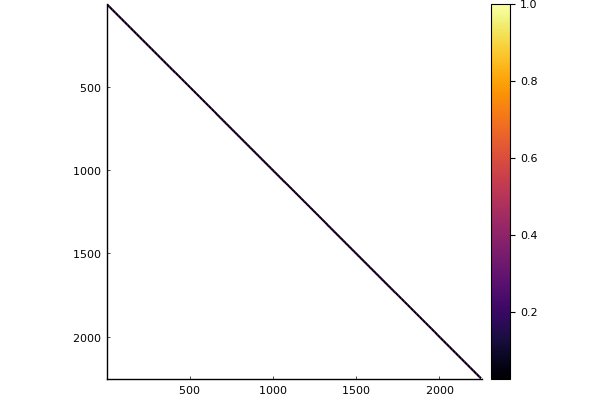

In [12]:
spy(QRFull)

## Define the Constraints

For the simple rocket soft-landing problem, we will include 5 constraints:
1. Dynamics Constraints ($A \tau = B$)
2. Initial and Terminal Constraints ($x[0] = x_0$ and $x[N] = x_N$)
2. Crash Prevention Constraint ($z > 0$)
3. Thrust Magnitude Bounds ($||u||_2 < u_{max}$)
4. Thurst Angle Bounds ($||[u_x; u_y]|| ≤ \alpha \ u_z$)

In [13]:
# Add the Dynamics Constraints
const AStack, BStack = rocketDynamicsStack(rocket, num_controls, N)

problem.constraints += AStack * tau == BStack

1-element Array{Constraint,1}:
 == constraint (affine)
├─ * (affine; real)
│  ├─ 1500×2256 SparseMatrixCSC{Float64,Int64}
│  └─ 2256-element real variable (id: 439…107)
└─ 1500×1 SparseMatrixCSC{Float64,Int64}

In [14]:
# Add Initial and Terminal Constraints
large_num = 10000

problem.constraints += tau[1:6] == rocketStart
problem.constraints += tau[7:(end - 6)] > -large_num
problem.constraints += tau[(end - 5):end] == rocketEnd

4-element Array{Constraint,1}:
 == constraint (affine)
├─ * (affine; real)
│  ├─ 1500×2256 SparseMatrixCSC{Float64,Int64}
│  └─ 2256-element real variable (id: 439…107)
└─ 1500×1 SparseMatrixCSC{Float64,Int64}
 == constraint (affine)
├─ index (affine; real)
│  └─ 2256-element real variable (id: 439…107)
└─ 6-element Array{Float64,1}
 >= constraint (affine)
├─ index (affine; real)
│  └─ 2256-element real variable (id: 439…107)
└─ -10000
 == constraint (affine)
├─ index (affine; real)
│  └─ 2256-element real variable (id: 439…107)
└─ 6-element Array{Float64,1}

In [15]:
# Add the Ground Constraint
ground_mat = spzeros(var_size, var_size)

currInd = 3
currRow = 1
while currRow <= N
    ground_mat[currRow, currInd] = 1

    currRow += 1
    currInd += 3 * Int(num_states / 2)
end

problem.constraints += ground_mat * tau > 0

5-element Array{Constraint,1}:
 == constraint (affine)
├─ * (affine; real)
│  ├─ 1500×2256 SparseMatrixCSC{Float64,Int64}
│  └─ 2256-element real variable (id: 439…107)
└─ 1500×1 SparseMatrixCSC{Float64,Int64}
 == constraint (affine)
├─ index (affine; real)
│  └─ 2256-element real variable (id: 439…107)
└─ 6-element Array{Float64,1}
 >= constraint (affine)
├─ index (affine; real)
│  └─ 2256-element real variable (id: 439…107)
└─ -10000
 == constraint (affine)
├─ index (affine; real)
│  └─ 2256-element real variable (id: 439…107)
└─ 6-element Array{Float64,1}
 >= constraint (affine)
├─ * (affine; real)
│  ├─ 2256×2256 SparseMatrixCSC{Float64,Int64}
│  └─ 2256-element real variable (id: 439…107)
└─ 0

In [16]:
# Add Thrust Magnitude Bounds

perWeightMax = 2

problem.constraints += norm(tau[7:9], 2) < mass * norm(grav[3]) * perWeightMax

6-element Array{Constraint,1}:
 == constraint (affine)
├─ * (affine; real)
│  ├─ 1500×2256 SparseMatrixCSC{Float64,Int64}
│  └─ 2256-element real variable (id: 439…107)
└─ 1500×1 SparseMatrixCSC{Float64,Int64}
 == constraint (affine)
├─ index (affine; real)
│  └─ 2256-element real variable (id: 439…107)
└─ 6-element Array{Float64,1}
 >= constraint (affine)
├─ index (affine; real)
│  └─ 2256-element real variable (id: 439…107)
└─ -10000
 == constraint (affine)
├─ index (affine; real)
│  └─ 2256-element real variable (id: 439…107)
└─ 6-element Array{Float64,1}
 >= constraint (affine)
├─ * (affine; real)
│  ├─ 2256×2256 SparseMatrixCSC{Float64,Int64}
│  └─ 2256-element real variable (id: 439…107)
└─ 0
 <= constraint (convex)
├─ norm2 (convex; positive)
│  └─ index (affine; real)
│     └─ 2256-element real variable (id: 439…107)
└─ 19.62

## Select the solver options

For more information, please visit https://github.com/RoboticExplorationLab/Altro.jl/blob/master/README.md for more details on the solver options.

Using the Altro package, we can now specify parameters and solve the problem.

# Step 2: Solve the initial trajectory optimization problem

Show summary is set to <code>true</code> to print the solver speed. In general the solve will take about 30 iterations and 65-80 ms to complete. 

In [17]:
problem

minimize
└─ * (convex; positive)
   ├─ 1
   └─ qol_elem (convex; positive)
      ├─ norm2 (convex; positive)
      │  └─ …
      └─ [1.0]
subject to
├─ == constraint (affine)
│  ├─ * (affine; real)
│  │  ├─ 1500×2256 SparseMatrixCSC{Float64,Int64}
│  │  └─ 2256-element real variable (id: 439…107)
│  └─ 1500×1 SparseMatrixCSC{Float64,Int64}
├─ == constraint (affine)
│  ├─ index (affine; real)
│  │  └─ 2256-element real variable (id: 439…107)
│  └─ 6-element Array{Float64,1}
├─ >= constraint (affine)
│  ├─ index (affine; real)
│  │  └─ 2256-element real variable (id: 439…107)
│  └─ -10000
├─ == constraint (affine)
│  ├─ index (affine; real)
│  │  └─ 2256-element real variable (id: 439…107)
│  └─ 6-element Array{Float64,1}
├─ >= constraint (affine)
│  ├─ * (affine; real)
│  │  ├─ 2256×2256 SparseMatrixCSC{Float64,Int64}
│  │  └─ 2256-element real variable (id: 439…107)
│  └─ 0
└─ <= constraint (convex)
   ├─ norm2 (convex; positive)
   │  └─ index (affine; real)
   │     └─ …
   └─ 19.62


Now we can solve it and show the summary

In [18]:
solve!(problem, ECOS.Optimizer)


ECOS 2.0.5 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.244e+07  +4e+07  2e-01  8e-01  1e+00  9e+03    ---    ---    1  1  - |  -  - 
 1  -9.118e+01  -5.909e+06  +1e+07  7e-02  2e-01  2e+03  3e+03  0.9215  2e-01   1  1  1 |  0  0
 2  -7.530e+01  -4.186e+06  +7e+06  6e-02  1e-01  2e+03  2e+03  0.7833  5e-01   1  1  1 |  0  0
 3  -6.570e+00  -3.462e+05  +6e+05  5e-03  1e-02  2e+02  1e+02  0.9115  1e-03   1  1  1 |  0  0
 4  -2.510e+01  -3.049e+05  +5e+05  5e-03  5e-03  1e+02  1e+02  0.9890  7e-01   1  1  1 |  0  0
 5  -2.415e+00  -2.774e+05  +4e+05  4e-03  2e-03  1e+02  9e+01  0.4083  7e-01   1  1  1 |  0  0
 6  +3.425e+01  -1.058e+05  +2e+05  2e-03  5e-04  5e+01  3e+01  0.7960  2e-01   1  1  1 |  0  0
 7  +3.241e+00  -3.817e+03  +6e+03  7e-05  1e-05  2e+00  1e+00  0.9853  2e-02   1  1  1 |  0  0
 8  +3.457e+00  -1.677e+03  +3e+03  3e-05  5e-

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\Daniel N\.julia\packages\Convex\aYxJA\src\solution.jl:252


In [19]:
@btime solve!($problem, ECOS.Optimizer(verbose = 0), verbose = false)

  69.419 ms (55015 allocations: 7.72 MiB)


In [20]:
@benchmark solve!($problem, ECOS.Optimizer(verbose = 0), verbose = false)

BenchmarkTools.Trial: 
  memory estimate:  7.72 MiB
  allocs estimate:  55015
  --------------
  minimum time:     68.499 ms (0.00% GC)
  median time:      70.787 ms (0.00% GC)
  mean time:        73.104 ms (0.84% GC)
  maximum time:     88.877 ms (10.11% GC)
  --------------
  samples:          69
  evals/sample:     1

In [21]:
problem

minimize
└─ * (convex; positive)
   ├─ 1
   └─ qol_elem (convex; positive)
      ├─ norm2 (convex; positive)
      │  └─ …
      └─ [1.0]
subject to
├─ == constraint (affine)
│  ├─ * (affine; real)
│  │  ├─ 1500×2256 SparseMatrixCSC{Float64,Int64}
│  │  └─ 2256-element real variable (id: 439…107)
│  └─ 1500×1 SparseMatrixCSC{Float64,Int64}
├─ == constraint (affine)
│  ├─ index (affine; real)
│  │  └─ 2256-element real variable (id: 439…107)
│  └─ 6-element Array{Float64,1}
├─ >= constraint (affine)
│  ├─ index (affine; real)
│  │  └─ 2256-element real variable (id: 439…107)
│  └─ -10000
├─ == constraint (affine)
│  ├─ index (affine; real)
│  │  └─ 2256-element real variable (id: 439…107)
│  └─ 6-element Array{Float64,1}
├─ >= constraint (affine)
│  ├─ * (affine; real)
│  │  ├─ 2256×2256 SparseMatrixCSC{Float64,Int64}
│  │  └─ 2256-element real variable (id: 439…107)
│  └─ 0
└─ <= constraint (convex)
   ├─ norm2 (convex; positive)
   │  └─ index (affine; real)
   │     └─ …
   └─ 19.62


Access the Trajectory

In [22]:
display(problem.optval)
display(rocketStart)
result_traj = evaluate(tau)

3541.2860400919276

6-element Array{Float64,1}:
   5.0
   5.0
  20.0
   0.0
   0.0
 -15.0

2256-element Array{Float64,1}:
   4.999999999999285
   4.999999999999285
  19.99999999997083
  -1.0108837898226777e-12
  -1.0108837898764586e-12
 -15.000000000026136
   1.5149120710267643
   1.5149120710267674
 -17.08900006932598
   4.992425439643356
   4.992425439643356
  18.53639500028596
  -0.15149120710462888
   ⋮
  -5.174098278031562e-6
  -5.174098278031559e-6
  -0.000532017505054822
  -5.174099255398818e-5
  -5.174099255398808e-5
  -9.815320219255218
  -6.341094633545689e-13
  -6.341094633546284e-13
  -7.971709111885264e-9
   4.886832488313711e-13
   4.886832488315085e-13
   2.210233673333514e-9

In [23]:
function getXVU(tau)
    kStart = 1
    maxK = length(tau)
    # println("Max = $maxK")

    xList = []
    vList = []
    uList = []

    while kStart < (maxK - 2 * num_controls)
        # println("Accessing $kStart to $(kStart + 3 * nDim - 1)")
        push!(xList, evaluate(tau)[kStart:kStart + num_controls - 1])
        push!(vList, evaluate(tau)[kStart + num_controls:kStart + 2 * num_controls - 1])
        push!(uList, evaluate(tau)[kStart + 2 * num_controls:kStart + 3 * num_controls - 1])

        kStart = kStart + 3 * num_controls
    end
    
    return xList, vList, uList
end

xList, vList, uList = getXVU(tau);

In [24]:
xs = [x[1] for x in xList]
ys = [x[2] for x in xList]
zs = [x[3] for x in xList];

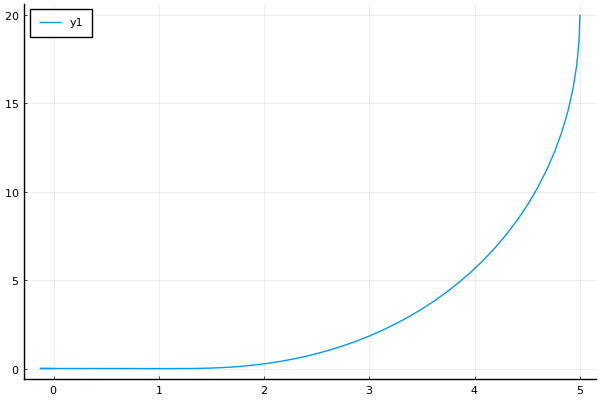

In [25]:
plot(xs, zs)

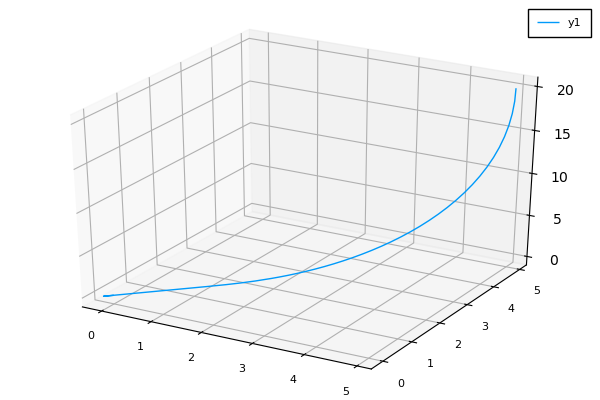

sys:1: MatplotlibDeprecationWarning: Additional positional arguments to set_ticklabels are ignored, and deprecated since Matplotlib 3.1; passing them will raise a TypeError in Matplotlib 3.3.


In [26]:
plot3d(xs, ys, zs)

In [27]:
uxs = [u[1] for u in uList]
uys = [u[2] for u in uList]
uzs = [u[3] for u in uList];

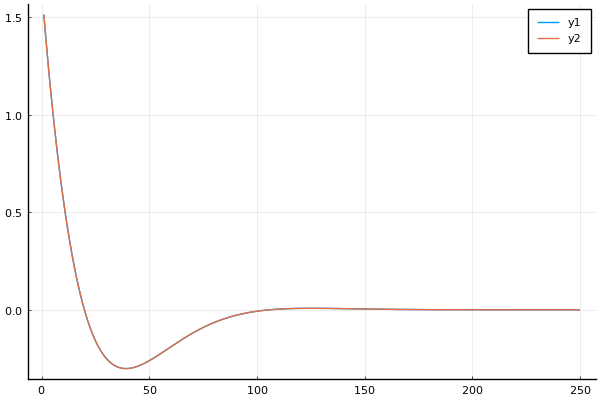

In [28]:
plot(uxs)
plot!(uys)

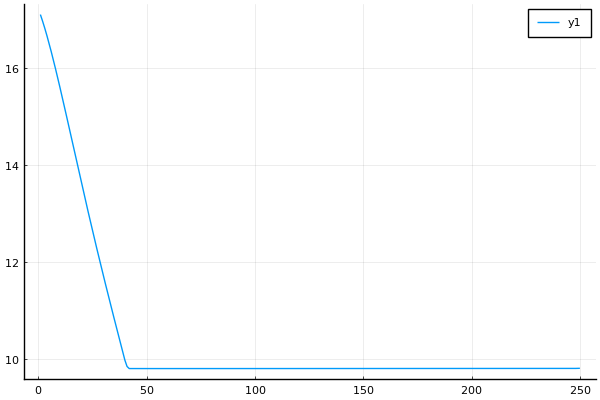

In [29]:
plot(-uzs)

## Step 3: Integrate the Dynamics to Verify the Dynamics Constraint

In Matlab, we would use ODE 45, but in the <code>DifferentialEquations.jl</code> package we can either (1) just let the <code>solve</code> method figure it out or (2) specify a solver such as <code>Tsit5</code>.

In [30]:
num_timesteps = N - 5

get_controls(t) = uList[min(Int(floor(t/deltaTime)) + 1, size(uList,1))]

A, B, g = rocketDynamicsContinuousMat(rocket, num_controls)

f(y,p,t) = A * y + B * get_controls(t) + g * grav

states_y0 = rocketStart
tspan = (0.0, deltaTime * num_timesteps)
controls_p0 = get_controls(tspan[1])

# Use the DifferentialEquations.jl Package
ode_prob = ODEProblem(f, states_y0, tspan, controls_p0,saveat=deltaTime)
ode_sol = solve(ode_prob, Tsit5(), reltol=1e-10, abstol=1e-10);

In [31]:
xvList = [[xList[i]; vList[i]] for i = 1:size(xList, 1)]

err = norm.(ode_sol.u - xvList[1:(Int(round(tspan[2]/deltaTime))+1)]);

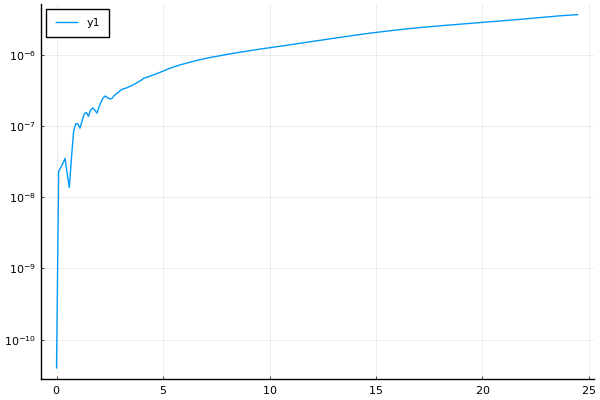

In [32]:
plot(ode_sol.t, err, yaxis = :log)